<a href="https://colab.research.google.com/github/vmjs1234/DECISION_TREE_AND_ENSEMBLE/blob/main/2)_random_forest_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from collections import Counter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

 # Define the Decision Tree Class

In [5]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])

    def _predict(self, inputs):
        node = self.tree
        while not node.is_leaf_node():
            if inputs[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if (depth >= self.max_depth or num_labels == 1 or
                num_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(num_features, num_features, replace=True)

        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        num_samples = len(y)
        num_left, num_right = len(left_idxs), len(right_idxs)
        e_left, e_right = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (num_left / num_samples) * e_left + (num_right / num_samples) * e_right

        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


##Define the Random Forest Class

In [6]:
class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=5):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                                max_depth=self.max_depth)
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_preds]
        return np.array(y_pred)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]


 ## Load Data and Train the Model

In [7]:
# Load dataset
data = load_iris()
X, y = data.data, data.target

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
clf = RandomForest(n_trees=10, max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")


Accuracy: 1.000


##Visualizing Feature Importance

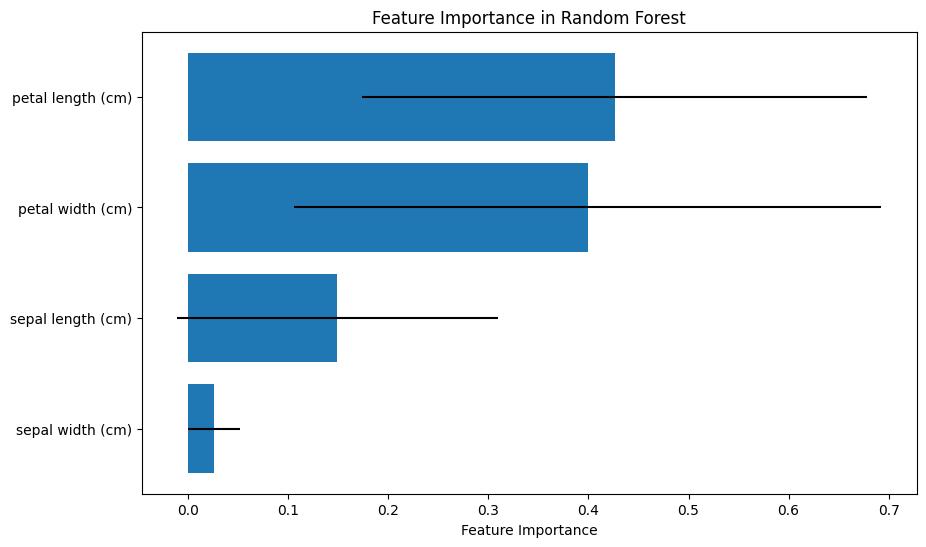

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load dataset
data = load_iris()
X, y = data.data, data.target
feature_names = data.feature_names

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

# Create a DataFrame for visualization
forest_importances = pd.DataFrame({'feature': feature_names, 'importance': importances, 'std': std})

# Sort by importance
forest_importances = forest_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(forest_importances['feature'], forest_importances['importance'], xerr=forest_importances['std'], align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()


## Visualizing Decision Boundaries

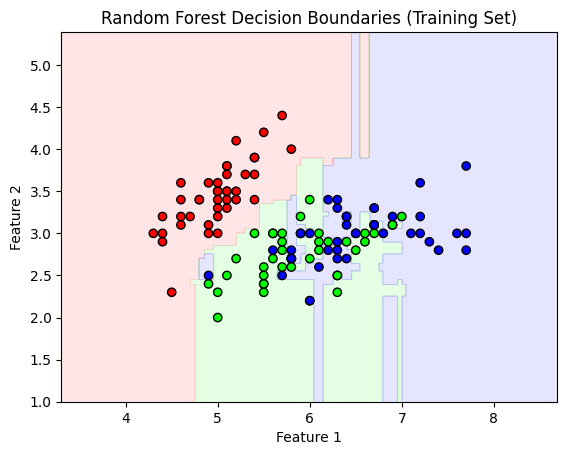

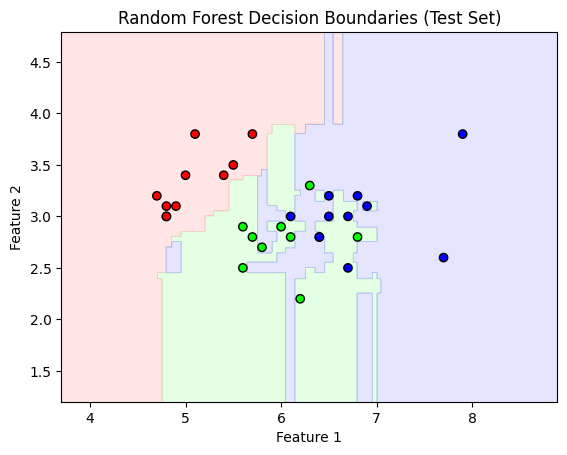

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

# Load dataset
data = load_iris()
X, y = data.data[:, :2], data.target  # Using only the first two features for 2D visualization

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Define the decision boundary plotting function
def plot_decision_boundaries(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF']))
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=ListedColormap(['#FF0000', '#00FF00', '#0000FF']))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

# Plot decision boundaries
plot_decision_boundaries(X_train, y_train, clf, 'Random Forest Decision Boundaries (Training Set)')
plot_decision_boundaries(X_test, y_test, clf, 'Random Forest Decision Boundaries (Test Set)')


 ## Visualizing Individual Decision Trees

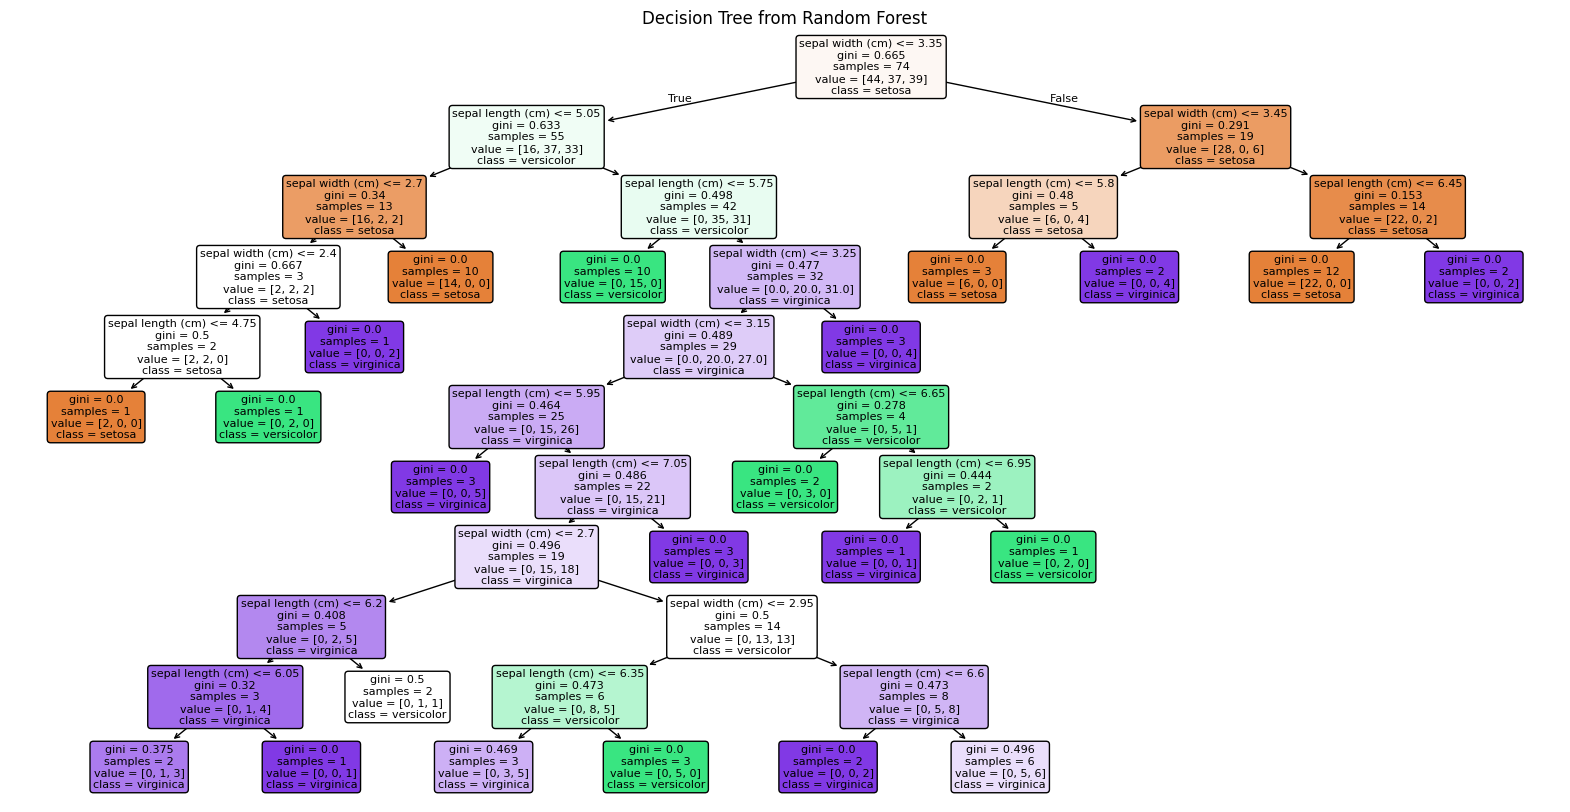

In [10]:
from sklearn.tree import plot_tree

# Visualize one of the trees in the Random Forest
plt.figure(figsize=(20, 10))
plot_tree(clf.estimators_[0], feature_names=data.feature_names, class_names=data.target_names, filled=True, rounded=True)
plt.title('Decision Tree from Random Forest')
plt.show()
